# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [4]:
PATH = "data/demand-forecasting/"

# Helper Functions

In [5]:
def smape(y_pred,y_true):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [6]:
def print_scores(pred,label):
    rmse = np.sqrt(mean_squared_error(pred,label))
    mae = mean_absolute_error(pred,label)
    smape_score = smape(pred,label)
    
    print('RMSE: ' + str(rmse))
    print('MAE: ' + str(mae))
    print('SMAPE: ' + str(smape_score))

In [7]:
def plot_preds(pred,label):  
    
    plt.xlabel('Actual Y ')
    plt.ylabel('Predicted Y')
    
    x = np.linspace(0.0, 200.0)
    y = x
    plt.plot(x, y, 'r')
    
    plt.scatter(label,pred,alpha=0.2)
    plt.show()

# Pre-Process Data

In [8]:
train = pd.read_csv(f'{PATH}train.csv', parse_dates=['date'])
test = pd.read_csv(f'{PATH}test.csv', parse_dates=['date'], index_col='id')

In [9]:
train['y'] = train['date'].dt.year
train['m'] = train['date'].dt.month
train['d'] = train['date'].dt.day
train['dw'] = train['date'].dt.dayofweek
train['dy'] = train['date'].dt.dayofyear
train.drop('date', axis=1, inplace=True)

sales = train.pop('sales')

In [10]:
test['y'] = test['date'].dt.year
test['m'] = test['date'].dt.month
test['d'] = test['date'].dt.day
test['dw'] = test['date'].dt.dayofweek
test['dy'] = test['date'].dt.dayofyear
test.drop('date', axis=1, inplace=True)

# Split Training-Validation Data

In [11]:
train.shape, sales.shape, test.shape

((913000, 7), (913000,), (45000, 7))

In [12]:
X_val = train.loc[(train.y==2017) & ((train.m==10) | (train.m==11) | (train.m==12))].copy() 
y_val = sales[X_val.index].copy()

X_train = train.drop(X_val.index).copy()
y_train = sales.drop(X_val.index).copy()

In [13]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((867000, 7), (867000,), (46000, 7), (46000,))

In [14]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
print()

# Random Forest

## With Validation Set

In [15]:
%%time
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
rf.fit(X_train, y_train)

Wall time: 3min 15s


In [16]:
predictions_train = rf.predict(X_train)
print_scores(predictions_train, y_train)

RMSE: 3.008640119848376
MAE: 2.302458419838524
SMAPE: 5.287038411713342


In [17]:
predictions_val = rf.predict(X_val)
print_scores(predictions_val, y_val)

RMSE: 8.637454389044615
MAE: 6.6357547826086964
SMAPE: 13.998225455443327


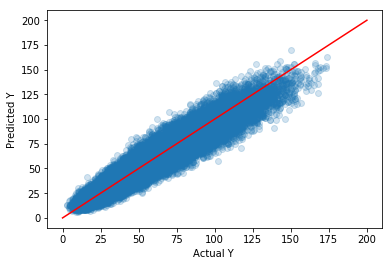

In [18]:
plot_preds(predictions_val, y_val)

## All In

In [19]:
%%time
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
rf.fit(train, sales)

Wall time: 3min 38s


In [20]:
y_pred = rf.predict(test)

In [21]:
test['sales'] = y_pred

# Submission

In [22]:
submission = pd.read_csv(f'{PATH}test.csv', index_col='id')

In [23]:
submission['sales'] = y_pred

In [26]:
csv_fn = f'{PATH}tmp/RF_v1a.csv'

In [27]:
submission[['sales']].to_csv(csv_fn)

__KAGGLE PUBLIC SCORE:__
- 15.54078 (without dayofyear feature, very close to the validation score 15.45) 
- 16.27342 (with dayofyear)